# 门控循环单元（GRU）
## 从零开始实现
### 1.初始化模型参数

In [4]:
import torch
from torch import nn 
import sys
sys.path.append("../")
import mytorch

batch_size, num_steps = 32, 35
train_iter, vocab = mytorch.load_data_time_machine(batch_size, num_steps)

def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    W_xz, W_hz, b_z = three() # 更新门参数
    W_xr, W_hr, b_r = three() # 重置门参数
    W_xh, W_hh, b_h = three() # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 2. 定义模型

In [5]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h,W_hq,b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X@W_xz)+(H@W_hz) + b_z)
        R = torch.sigmoid((X@W_xr) + (H@W_hr) + b_r)
        H_tilda = torch.tanh((X@W_xh) + ((R*H)@ W_hh) +b_h)
        H = Z * H + (1-Z)*H_tilda
        Y = H @ W_hq +b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### 3. 训练与预测

困惑度 1.1, 5942.0 词元/秒 mps
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


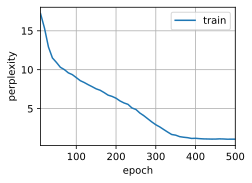

In [6]:
vocab_size, num_hiddens, device = len(vocab), 256, mytorch.try_gpu()
num_epochs, lr = 500, 1
model = mytorch.RNNModelScratch(vocab_size,num_hiddens, device, get_params, init_gru_state, gru)

mytorch.train_ch8(model,train_iter, vocab, lr, num_epochs, device)

## 简洁实现

time travellerqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq


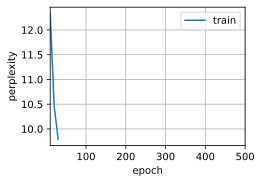

In [7]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = mytorch.RNNModel(gru_layer, len(vocab))
model = model.to(device)
mytorch.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

import numpy as np